# BTC vs ETH Performance Analysis (2017 - 2025)

*In this notebook, I'll analyze and compare Bitcoin (as the **"BTC-USD"** currency pair) and Ethereum (as the **"ETH-USD"** currency pair) over the past 7 years using daily price data.
The main goal is to understand their growth, risk and return characteristics through simple quantitative metrics like **Returns,** **Volatility**, **Sharpe Ratio** and **Drawdowns**.*)

## 1. Importing Libraries & Seting up

Using the **"yfinance"** API (Yahoo Finance) to fetch historical data and the Python Libraries (**"pandas"** for data frames, **"numpy"** for calculation and **"matplotlib"** for visualization / plotting).

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
%config InlineBackend.figure_format = "svg"

---

## 2. Data Import & Quick formatting

Fetching the OHLCV data for BTC and ETH from Yahoo Finance and drop unnecesary columns.

In [2]:
btc = yf.Ticker("BTC-USD").history(start = "2017-11-1" , end = "2025-10-1")
eth = yf.Ticker("ETH-USD").history(start = "2017-11-1" , end = "2025-10-1")

btc = btc.drop(columns = ["Dividends", "Stock Splits"]) 
eth = eth.drop(columns = ["Dividends", "Stock Splits"]) 

---

### 3. Normalized Growth Comparison

We'll compare how BTC and ETH have grown over time by normalizing prices, for a fair comparison.

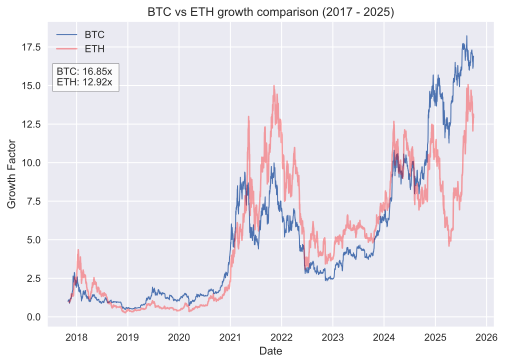

In [3]:
# Normalizing:
btc_normalized = btc["Close"] / btc["Close"].iloc[0]
eth_normalized = eth["Close"] / eth["Close"].iloc[0]

# End growth factor:
btc_growth = btc_normalized.iloc[-1] 
eth_growth = eth_normalized.iloc[-1]

# Plotting:
plt.plot(btc_normalized, label = "BTC", linewidth = 1)
plt.plot(eth_normalized, label = "ETH", linewidth = 1.5, color = "red", alpha = 0.35)
plt.title("BTC vs ETH growth comparison (2017 - 2025)")
plt.ylabel("Growth Factor")
plt.xlabel("Date")
plt.text(0.02, 0.85, f"BTC: {btc_growth:.2f}x \nETH: {eth_growth:.2f}x",
         transform = plt.gca().transAxes, fontsize = 10, va = "top",
         bbox = dict(facecolor = "white", alpha = 0.8))
plt.legend();

---

## 4.Returns (Simple & Logarithmic)

Computing both the **Simple** and **Logarithmic** Returns, to measure individual percentage changes and compounded returns overtime.
The returns will be also used later, to calculate the **Volatility, Sharpe Ratio and Drawdown** of both assets.

In [4]:
# Simple
btc["Simple Return"] = btc["Close"].pct_change()
eth["Simple Return"] = eth["Close"].pct_change()

# Logarithmic
btc["Log Return"] = np.log(btc["Close"] / btc["Close"].shift(1))
eth["Log Return"] = np.log(eth["Close"] / eth["Close"].shift(1))

# Cumulative (from the Logoarithmic)
btc["Cumulative Log"] = np.exp(btc["Log Return"].cumsum())
eth["Cumulative Log"] = np.exp(eth["Log Return"].cumsum())

# Annual average returns
btc_annual_return = np.exp(btc["Log Return"].mean() * 365) - 1
eth_annual_return = np.exp(eth["Log Return"].mean()* 365) - 1

---

## 5.Statistics of Returns

Going over the Mean, Standard Deviation and Best / Worst perfoming days of BTC and ETH's returns to quantify their behaviors.

In [9]:
# .describe provides us with the Mean, Standard Deviation, percentiles of the average Returns, Minimum (worst day) and Maximum (best day)
btc_stats = btc["Log Return"].describe().T
eth_stats = eth["Log Return"].describe().T

In [6]:
print("   BTC Statistics")
print(btc_stats)

print("\n   ETH Statistics")
print(eth_stats)

   BTC Statistics
count    2890.000000
mean        0.000977
std         0.035595
min        -0.464730
25%        -0.013578
50%         0.000830
75%         0.015906
max         0.225119
Name: Log Return, dtype: float64

   ETH Statistics
count    2882.000000
mean        0.000888
std         0.045729
min        -0.550732
25%        -0.018753
50%         0.000767
75%         0.021791
max         0.234741
Name: Log Return, dtype: float64


### Stat Summary
#### **Mean** 
* **BTC:** 0.0977%
* **ETH:** 0.0888%
  
  *Both assets showing positive returns, with BTC slightly higher*.

#### **Standard Deviation (Volatility)** 
* **BTC:** 3.56%
* **ETH:** 4.57%
  
  *ETH has a higher daily volatility than BTC*.

#### **Minimum Daily Return** 
* **BTC:** -46.47%
* **ETH:** -55.07%
  
  *ETH experienced deeper single-day drawdowns*.

#### **Maximum Daily Return** 
* **BTC:** 22.51%
* **ETH:** 23.47%
  
  *Both assets show similar upside spikes, with ETH slightly higher*.

**Overall, BTC shows slightly steadier growth, while ETH exhibits higher volatility and larger swings**.

---


## 6. Sharpe Ratio

The **Sharpe Ratio** measues the risk-adjusted return of an asset. Simply said, it tells you how much return you are getting per unit of risk. A higher sharpe ratio = better risk-adjusted performance - a better "bang for your buck" if you will.

In [7]:
# Sharpe = Mean of the Logarithmic Returns divided by The Logarithmic Returns's Standard Deviation multiplied by the square-root of the trading days (365 for cryptocurrency markets)
sharpe_btc = (btc["Log Return"].mean() / btc["Log Return"].std() * np.sqrt(365))
sharpe_eth = (eth["Log Return"].mean() / eth["Log Return"].std() * np.sqrt(365))

print(f"BTC Sharpe Ratio: {sharpe_btc:.2f}")
print(f"ETH Sharpe Ratio: {sharpe_eth:.2f}")

BTC Sharpe Ratio: 0.52
ETH Sharpe Ratio: 0.37


#### Interperatation

* BTC is **more efficient** at turning risk into return than ETH in the analyzed timeframe.
* Even if ETH sometimes has higher raw returns, its **higher volatility** skews its risk-adjusted efficiency.
* A higher sharpe simply shows a bigger compensation for risk-taken



---

## 7. Drawdown Analysis
A drawdown analysis of an asset will achieve three main things:
* Measuring the decline of an asset from it's previous peak.
* Shows the risk of losing your capital during a period of investing
* Find out the Maximum Drawdown (MDD for short), which is the **largest drop, relative from the peak of an asset**.

*To gather this information, what is needed is:*
1. Have the Cumulative Returns.
2. Compute the maximum **(peak)** at each point.
3. Compute the drawdows - how much the asset is **below** its peak
4. Identify the **MDD** for each asset.

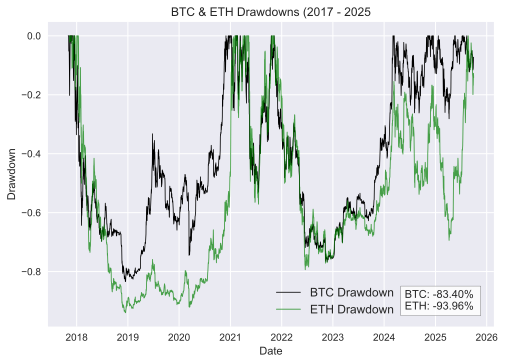

In [8]:
# 1. Cumulative Returns✅

# 2. Computing the peak of each asset
btc_peak = btc["Cumulative Log"].cummax()
eth_peak = eth["Cumulative Log"].cummax()

# 3. Drawdowns
btc_drawdown = (btc["Cumulative Log"] - btc_peak) / btc_peak
eth_drawdown = (eth["Cumulative Log"] - eth_peak) / eth_peak

# 4. MDD
btc_mdd = btc_drawdown.min()
eth_mdd = eth_drawdown.min()

# Visualizing
plt.plot(btc_drawdown, label = "BTC Drawdown", linewidth = 0.8, color = "black")
plt.plot(eth_drawdown, label = "ETH Drawdown", linewidth = 0.9, color = "green", alpha = 0.7)
plt.title("BTC & ETH Drawdowns (2017 - 2025")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.text(0.80, 0.12, f"BTC: {btc_mdd * 100:.2f}% \nETH: {eth_mdd * 100:.2f}%",
         transform = plt.gca().transAxes, fontsize = 11, va = "top",
         bbox = dict(facecolor = "white", alpha = 0.8))
plt.legend(loc = "lower right", bbox_to_anchor=(0.8, 0), fontsize = 12);

#### Drawdown Analysis
*Both in late 2018:*
* **BTC**: Maximum Drawdown of **-83.40%**
* **ETH**: Maximum Drawdown of **-93.96%** 

### Interpretation
* There have been significant drops from the peaks of both assets, with ETH showing a **larger potential loss**, reflecting higher risk and volatility.
* BTC, while still risky, shows **slightly more stability** relative to ETH over this analyzed period.
* Drawdowns help with the understanding of **worst-case scenarios** and the potential risk of **large losses over time** - a sort of preparation using the worst historical cases.

---

# 📌 Summary 

* 📈**Growth Comparison**: BTC showed steadier growth, ETH had higher gains but also in the same time had more drastic swings.
* 💹**Risk-Adjusted Performance**: BTC has a higher Sharpe Ratio -> gives more return per unit of risk.
* ⚖️**Drawdown**: ETH had slightly larger peak-to-bottom drops, showing a slightly higher downside risk compared to BTC.

💡 Key Takeaway: **BTC** is a more moderate-risk, **slightly steadier asset**, whereas ETH has the **higher volatility** and **larger potential swings**.